# Latent Space Exploration and Manipulation with VAE

In [1]:
import sys 
import os 

sys.path.append(os.path.abspath(".."))

In [2]:
import torch
from torch import optim
import pandas as pd
from src.model import VAE
from src.train import train
from src.utils import load_celeba, visualize_celeba_examples, denormalize
from src.configs import celeba_configs
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [35]:
root = r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data\celeba\img_align_celeba"
img_list = os.listdir(root)
print(len(img_list))

202599


In [5]:
celeba_loader = load_celeba(root)

In [6]:
for batch in celeba_loader:
    print(f"{batch.shape}")
    break

torch.Size([128, 49152])


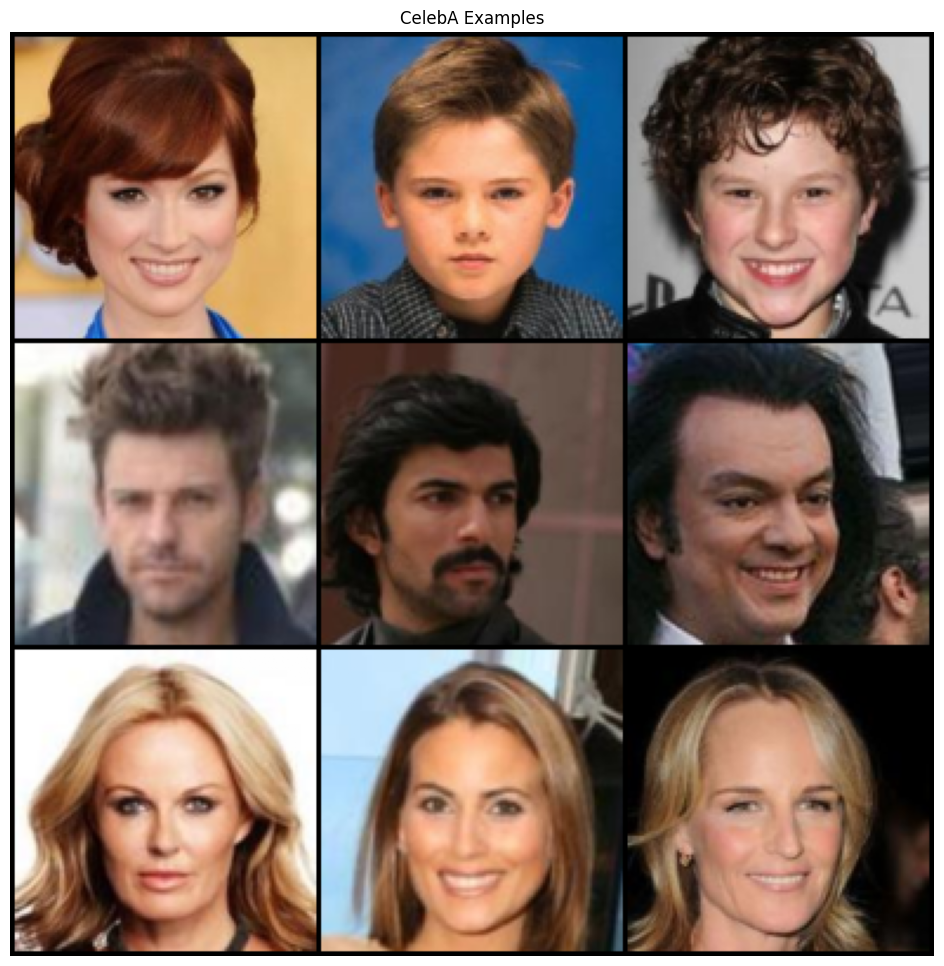

In [7]:
visualize_celeba_examples(dataloader=celeba_loader, num_examples=9, img_size=128,  fig_size=(12,12))

## Training

In [4]:
model = VAE(**celeba_configs, f_out='tanh').to(device)
model.load_state_dict(torch.load(r"C:\Users\Ángel\Documents\GitHub\vae-project\src\vae_celeba_trained.pth", map_location= device))

<All keys matched successfully>

In [5]:
model.eval()

VAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=49152, out_features=2048, bias=True)
      (1): ReLU()
      (2): Linear(in_features=2048, out_features=1024, bias=True)
      (3): ReLU()
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): ReLU()
    )
    (hidden2mu): Linear(in_features=512, out_features=256, bias=True)
    (hidden2logvar): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU()
      (4): Linear(in_features=1024, out_features=2048, bias=True)
      (5): ReLU()
    )
    (hidden2out): Linear(in_features=2048, out_features=49152, bias=True)
  )
)

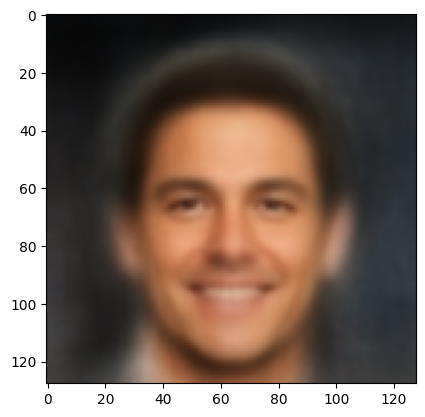

In [41]:
image = Image.open(r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data\celeba\img_align_celeba\000012.jpg").convert("RGB")

transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # We normalize the inputs to [-1, 1]. The 3 dimensions are because of the 3 RGB channels.
])

x = transform(image).to(device)

x = x.view(-1)

x_hat, mu, logvar = model(x)

x_hat = denormalize(x_hat)

with torch.no_grad():
    x_hat = x_hat.view(3, 128, 128).cpu().numpy()

x_hat = np.transpose(x_hat, (1,2,0))

plt.imshow(x_hat)

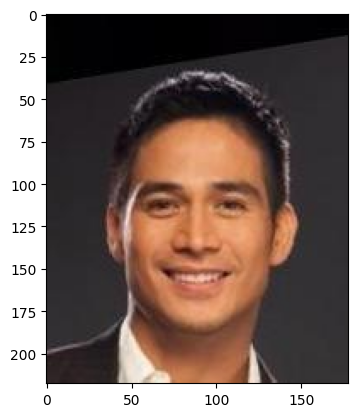

In [24]:
plt.imshow(image)

## Image Attibutes Filter

In [29]:
df = pd.read_csv(r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data\celeba\list_attr_celeba.csv", sep = ',')
df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [30]:
df.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

In [31]:
columns = ['Smiling', 'Male', 'Blond_Hair', 'No_Beard']
df = df.set_index('image_id')
df = df[columns]
df.head()

,Smiling,Male,Blond_Hair,No_Beard
image_id,,,,
000001.jpg,1,-1,-1,1
000002.jpg,1,-1,-1,1
000003.jpg,-1,1,-1,1
000004.jpg,-1,-1,-1,1
000005.jpg,-1,-1,-1,1


In [33]:
img_smile = df[df['Smiling'] == 1].index.tolist()
img_no_smile = df[df['Smiling'] == -1].index.tolist()

In [36]:
smile_loader = load_celeba(root, image_files=img_smile)
nosmile_loader = load_celeba(root, image_files= img_no_smile)

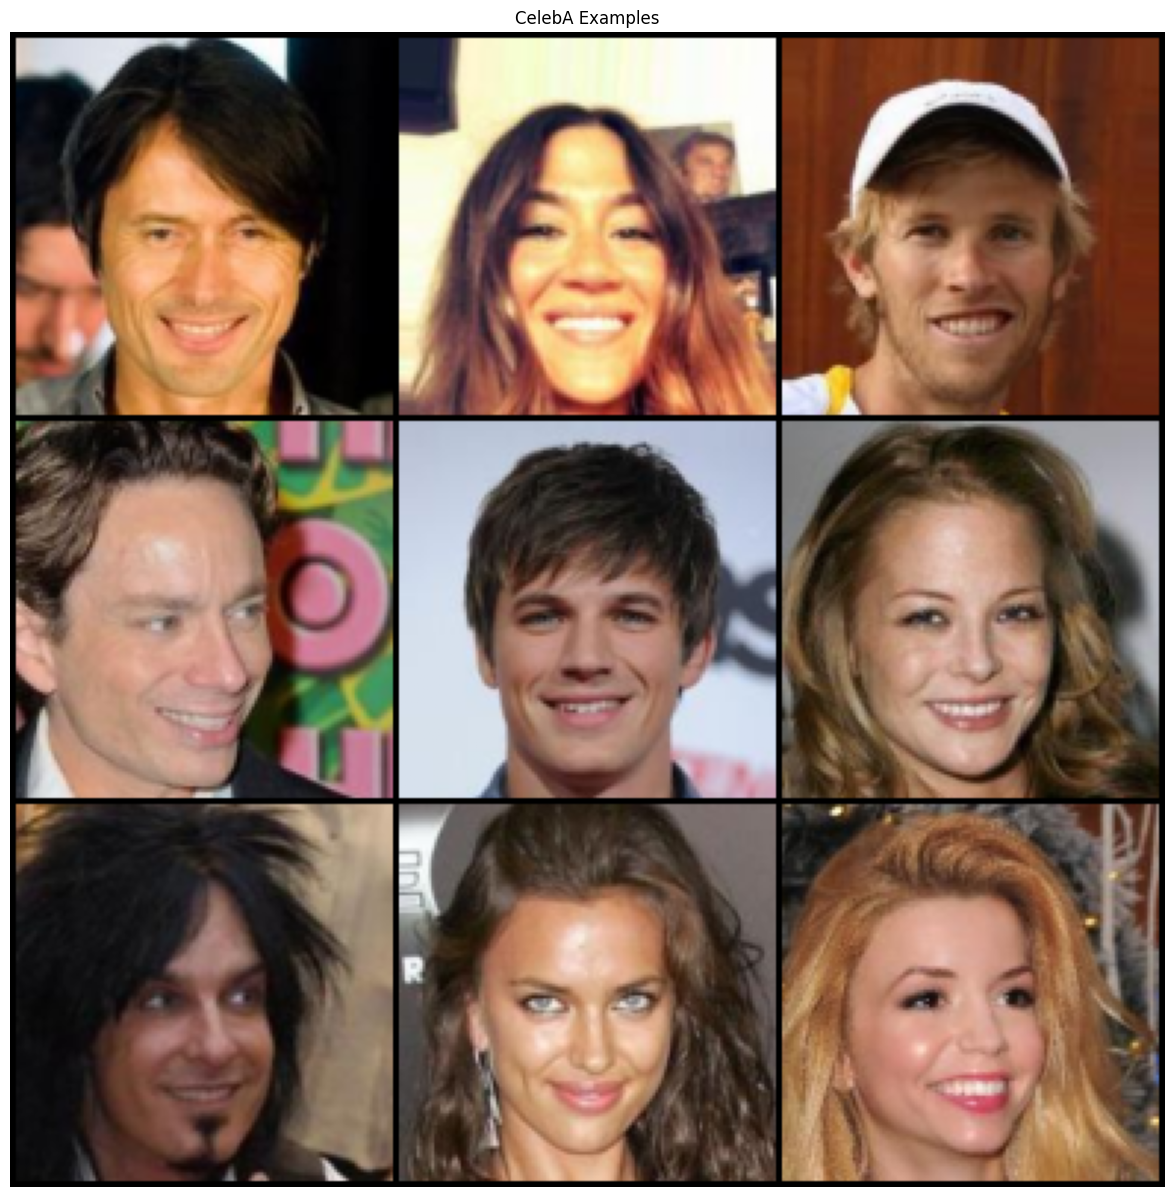

In [37]:
visualize_celeba_examples(smile_loader, num_examples=9, img_size=128)

In [62]:
def encode_latents(dataloader, model, device):
    latents = []

    with torch.no_grad():
        for imgs in dataloader:
            imgs = imgs.to(device)
            imgs = imgs.view(imgs.size(0), -1)
            mu, _ = model.encoder(imgs)
            latents.append(mu)
    
    return torch.cat(latents, dim = 0)

In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [64]:
device

device(type='cuda')

In [65]:
z_smile = encode_latents(smile_loader, model, device)
z_nosmile = encode_latents(nosmile_loader, model, device)

In [66]:
mean_smile = z_smile.mean(dim = 0)
mean_nosmile = z_nosmile.mean(dim = 0)
smile_dir = mean_smile-mean_nosmile
smile_dir.to(device)

tensor([ 1.9147e-03, -3.3010e-03, -3.3815e-05, -2.4374e-04,  5.6238e-03,
         1.1307e-03,  1.6837e-03, -1.0671e-03,  2.7201e-02,  1.7810e-03,
        -6.2485e-03,  8.9914e-05, -2.4290e-03,  2.0805e-03,  2.6928e-03,
        -2.2870e-03,  1.8510e-03, -1.3304e-03, -6.1940e-03, -2.1754e-03,
        -5.9001e-03,  9.4553e-05, -1.2231e-01, -3.8255e-04,  4.6062e-03,
         3.3355e-03,  1.3009e-03, -9.4192e-04, -4.9888e-03,  1.4453e-03,
        -3.8018e-03,  2.7578e-03, -6.2644e-03, -2.7405e-03, -1.6809e-03,
        -2.4882e-03, -2.9165e-03, -2.1481e-01, -4.7202e-03, -3.0571e-03,
         6.2122e-03,  5.4048e-03,  3.8407e-05,  8.2108e-02, -2.3500e-04,
         7.3913e-02,  1.8334e-03,  2.1642e-01, -5.0410e-03, -1.2219e-06,
        -1.2327e-03,  5.2330e-03,  1.9252e-03, -7.5341e-03,  3.2501e-03,
         1.3325e-03,  6.4299e-03,  1.7538e-04, -3.0380e-03, -2.5017e-03,
        -3.0267e-03,  7.1187e-03,  1.7132e-03,  3.6727e-03, -2.2779e-01,
        -2.9068e-03, -9.8911e-04,  2.8159e-03, -9.0

In [67]:
std = torch.exp(0.5 * logvar).to(device)
eps = torch.randn_like(std).to(device)
z = mu + eps * std
z = z.to(device)

In [102]:
alpha = torch.ones_like(smile_dir)*1
alpha = alpha.to(device)

In [103]:
z_modified = z + alpha * smile_dir

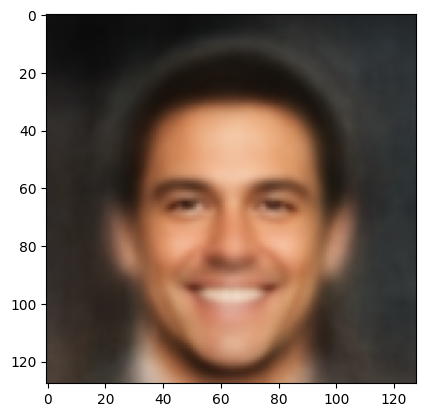

In [104]:
x_hat = model.decoder(z_modified)

x_hat = denormalize(x_hat)

with torch.no_grad():
    x_hat = x_hat.view(3, 128, 128).cpu().numpy()

x_hat = np.transpose(x_hat, (1,2,0))

plt.imshow(x_hat)